In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import scipy.stats as stats
import re
import math
from datetime import datetime
import importlib
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, LassoCV, RidgeClassifierCV
from sklearn.feature_selection import RFECV
from sklearn.model_selection import cross_val_score, train_test_split, KFold, StratifiedKFold, GridSearchCV 
from sklearn.metrics import roc_auc_score, roc_curve, log_loss, f1_score, confusion_matrix, precision_score, recall_score, classification_report;
import time

from sklearn.feature_selection import RFE
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_selection import chi2
import statsmodels.api as sm
from sklearn.model_selection import learning_curve, GridSearchCV

In [2]:
from autoscoring import IDF
from autoscoring.AS import *
from autoscoring.AS_2 import *
from autoscoring.Binning import transform_df_to_woe, construction_binning, correct_binning_dict, print_feature_bins

In [ ]:
# !pip install lightgbm

In [4]:
df = pd.read_excel('data/slkz_SolvaStreet.xlsx', sheet_name='result 1')

# Добавить, если имя целевой переменной отличается от 'target'
# df['target'] = 

df['date_requested'] = pd.to_datetime(df['date_requested'])
date_name = 'date_requested'  # Дата, по которой аггрегировать и оценивать gini/psi и т.д. по дефолту дата выдачи.
df_req = df[['credit_id', date_name]]
df['y'] = df['target']
y = df.y

In [5]:
# Удаляем лишние колонки, конкретный набор зависит от сэмпла.
cols_to_drop = [var for var in df.columns if 'SCORE' in var or 'scoring' in var or 'street' in var]
df.drop(cols_to_drop, axis=1, inplace=True)

In [6]:
# Filling missing values (np.nan, '_MISSING_')
cat_vars = df.select_dtypes(include=[object]).columns
df = filling(df)

min_num = 50
df, else_df = replace_not_frequent_2(df, cat_vars, num_min = min_num)

# Drop columns with only 1 value
df = drop_single_value_column(df)

In [7]:
# Если вы не разделяете сэмпл на df_out, то можете закомментировать этот кусок,
# и вместо него запустить:
# df_out, y_out = None, None

df_out = df[df['date_requested'] >= '2021-01-01']
df = df[df['date_requested'] < '2021-01-01']
y_out = df_out.y

In [8]:
df_train, df_test, y_train, y_test = train_test_split(df, df.y, test_size=0.2, stratify=df.y, random_state=123)

#### Построение WOE таблицы

In [10]:
# Задаём набор признаков для формирования биннинга.
# Набор колонок, который не будет учавствовать в построении карты
technical_features = ['credit_id', 'date_requested', 'type',
                        'target', 'y']
# Задаём набор признаков, которые будут учавствовать в биннинге,
# для этого удаляем все ненужные признаки из общего списка переменных.
features = df_train.drop(
    technical_features
, axis=1).columns

target_name = 'target'  # Наименование столбца - таргета
# Минимальное количество объектов в бине, по дефолту 0.05, требуется менять
# только в исключительных ситуациях
min_bin_size = 0.05
max_bin_count = 5  # Максимальное количество бинов при разбиении, по дефолту 5 - хороший вариант.
# Как определять WOE для пропусков, если их меньше чем min_bin_size:
# max - максимальное WOE
# max_cat - WOE самой крупной группы, можно оставить это по дефолту
# min - минимальное WOE
# zero - значение WOE становится 0
nan_to_woe = 'max_cat'
# Как определять WOE для _ELSE_ значений, если их меньше чем min_bin_size:
# max - максимальное WOE
# max_cat - WOE самой крупной группы, можно оставить это по дефолту
# min - минимальное WOE
# zero - значение WOE становится 0
else_to_woe = 'max_cat'
# Если True, то специально накладываются ограничения, чтобы WOE был монотонным по бинам,
# лучше оставить False, и потом в ручном режиме поменять, если не требуется обратного.
monotonic = False
n_jobs = 4  # Количество ядер для работы, чем больше тем быстрее, по дефолту 4.

iv_df, dropped_feats, feats, best_features, auto_woe = construction_binning(df_train, features, target_name,
                                                         max_bin_count=max_bin_count,
                                                         min_bin_size=min_bin_size,
                                                         nan_to_woe=nan_to_woe,
                                                         else_to_woe=else_to_woe,
                                                         monotonic=monotonic,
                                                         n_jobs=n_jobs)

# iv_df - таблицы WOE биннинга
# dropped_feats - набор переменных, для которых биннинг не посчитался,
# т.к. в переменной не нашлось сколько-нибудь хорошего разделения или признак практически константный
# feats - таблица полученная после предварительного отбора признаков, в которой указаны причины,
# по которым признак не очень хороший, можно игнорировать
# best_features - набор признаков после предварительного отбора внутри AutoML,
# можно использовать при дальнейшем отборе, можно проигнорировать
# auto_woe - техническая переменная, можно игнорировать

[LightGBM] [Info] Number of positive: 474, number of negative: 5268
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003408 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19198
[LightGBM] [Info] Number of data points in the train set: 5742, number of used features: 244
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.082550 -> initscore=-2.408199
[LightGBM] [Info] Start training from score -2.408199
ERROR in last days_from_fc_d_requested doesnt have information, [-2.235e+02  1.000e-05], 1


In [11]:
# Порог для фильтрации по IV.
# Требуется устанавливать в зависимости от количества признаков, но лучше сильно не ограничивать.
# Например если признаков меньше 200, то можно поставить iv_co = 0.01 или 0.02.
# Иначе можно поставить iv_co = 0.03 - 0.05.
iv_co = 0.01
vars = iv_df[iv_df['IV'] > iv_co]['VAR_NAME'].unique()
print(len(vars))

IV = iv_df[['VAR_NAME', 'IV']].drop_duplicates()
IV = IV[IV['VAR_NAME'].isin(vars)]

143


In [12]:
iv_co = None
X_train, y_train = transform_df_to_woe(df_train[vars], y_train, IV, iv_df, iv_cut_off=iv_co)
X_test, y_test = transform_df_to_woe(df_test[vars], y_test, IV, iv_df, iv_cut_off=iv_co)
X_out, y_out = transform_df_to_woe(df_out[vars], y_out, IV, iv_df, iv_cut_off=iv_co)

Features left after IV drop: 143
DONE!
Features left after IV drop: 143
DONE!
Features left after IV drop: 143
DONE!


In [14]:
X_train.columns = 'WOE_' + X_train.columns
X_test.columns = 'WOE_' + X_test.columns
X_out.columns = 'WOE_' + X_out.columns

#### Отбор признаков

Dropped columns: [] 

Features left after correlation check: 143 

Not dropped columns: ['WOE_days_from_fc_d_requested', 'WOE_credits_active_owner', 'WOE_credits_all_owner', 'WOE_monthly_instalments_owner', 'WOE_mnt_outstand_balance', 'WOE_his_w_pay_st_by_act_crd_days', 'WOE_his_w_pay_st_by_act_crd_sum', 'WOE_his_w_pay_st_by_cls_crd_days', 'WOE_his_w_pay_st_by_cls_crd_sum', 'WOE_act_div_all_crd', 'WOE_sum_per_cred', 'WOE_h_cl_sum_div_days', 'WOE_h_ac_sum_div_days', 'WOE_h_ac_sum_div_h_cl_sum', 'WOE_fc_credits_active_owner', 'WOE_fc_credits_all_owner', 'WOE_fc_monthly_instalments_owner', 'WOE_fc_mnt_outstand_balance', 'WOE_fc_his_w_pay_st_by_act_crd_days', 'WOE_fc_his_w_pay_st_by_act_crd_sum', 'WOE_fc_his_w_pay_st_by_cls_crd_days', 'WOE_fc_his_w_pay_st_by_cls_crd_sum', 'WOE_fc_act_div_all_crd', 'WOE_fc_sum_per_cred', 'WOE_fc_h_cl_sum_div_days', 'WOE_fc_h_ac_sum_div_days', 'WOE_fc_h_ac_sum_div_h_cl_sum', 'WOE_fcb_last_open_d_cr_act', 'WOE_fcb_last_open_d_cr_all', 'WOE_fcb_first_cred_open

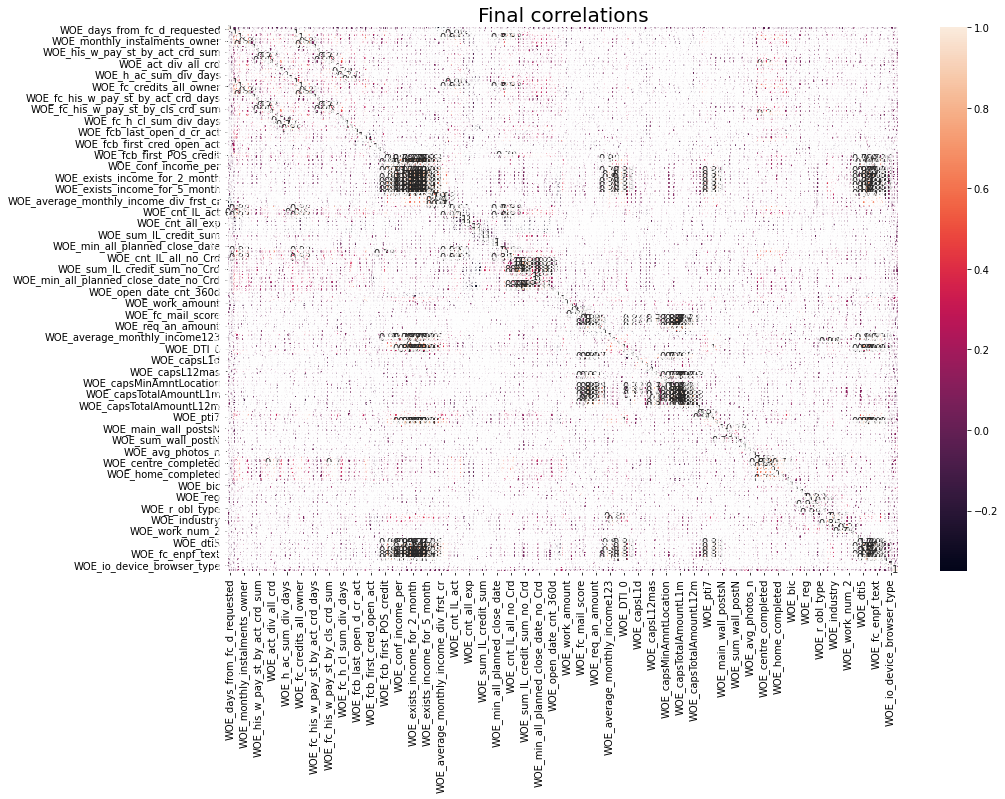

In [15]:
# Устанавливаем порого для фильтрации признаков по корреляциям.
# По дефолту 0.85 - оптимальное значение, в зависимости от требований
# можно поставить число в диапозоне 0.75 - 0.9.
cut_off = 0.85
X_train_corr = delete_correlated_features(X_train, cut_off=cut_off, is_plot_prev=False,
                                          exclude=[], IV_sort=True, iv_df=iv_df)

In [16]:
corr_feats = X_train_corr.columns

In [17]:
# Фильтруем признаки по следующему принципу:
# для каждого признака делаем однофакторный расчёт gini на train выборке для каждого месяца
# в разбивке по date_requested (обязательно должен присутствовать в df_train).
# После этого отфильтровываем признаки, для которых gini меньше чем gini_min
# для количества месяцев большего num_bad_months.
# Т.е. например, если gini_min=0.05 и num_bad_months=2, то если gini переменной больше 0.05 для всех месяцев, кроме одного - это ок. 
gini_min = 0.05  # 0.05 - по дефолту норм, можно взять в диапозоне 0.02 - 0.08 в зависимости от качества признаков.
num_bad_months = 2  # 2 месяца по дефолту норм, можно взять 10-20% от общего количества месяцев в сэмпле.
date_name = 'date_requested'  # Дата, по которой делить на месяцы.

gini_feats, df_gini_months = gini_month_selection(X_train[corr_feats], df_train, gini_min=gini_min,
                                                  num_bad_months=num_bad_months, date_name=date_name)

In [18]:
print(len(list(gini_feats)))
df_gini_months[df_gini_months['vars'].isin(gini_feats)]

101


,vars,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,2020-11,2020-12
1,WOE_credits_active_owner,0.030,0.122,0.166,0.133,0.216,0.101,0.179,0.185
2,WOE_credits_all_owner,0.124,0.039,0.320,0.209,0.268,0.229,0.293,0.390
3,WOE_monthly_instalments_owner,0.020,0.098,0.116,0.214,0.277,0.127,0.222,0.279
4,WOE_mnt_outstand_balance,0.016,0.022,0.090,0.166,0.311,0.149,0.271,0.189
6,WOE_his_w_pay_st_by_act_crd_sum,0.094,0.141,0.135,0.134,0.176,0.040,0.007,0.106
...,...,...,...,...,...,...,...,...,...
135,WOE_dti5,0.072,0.118,0.045,0.086,0.110,0.036,0.067,0.088
136,WOE_pti5,0.026,0.204,0.115,0.149,0.255,0.055,0.132,0.120
137,WOE_enpf_text,0.072,0.118,0.045,0.086,0.110,0.036,0.067,0.088
138,WOE_fc_enpf_text,0.062,0.130,0.028,0.082,0.083,0.043,0.058,0.091


In [19]:
# Отбираем признаки по их значимости во время построения Деревьев решений.
top_n = 60  # Количество лучшеих признаков, которые оставить. Можно брать в диапозоне 45-80.
rf_feats, rf_imp = rf_feature_selection(X_train[gini_feats], y_train, top_n=top_n)

In [20]:
# Отбираем признаки исходя из permutations_importance.
# Подробнее: https://www.kaggle.com/dansbecker/permutation-importance
top_n = 30  # Количество лучшеих признаков, которые оставить. Можно брать в диапозоне 30-50.
tf_feats, tf_imp = permutation_two_forest_selection(X_train[rf_feats], y_train, top_n=top_n)

In [86]:
# Делаем итоговый отбор признаков, он вычислительно затратный и более точный.
n_features = 8  # количество признаков, оптимально 7 - 14, меньше - быстрее посчитается.
selection_type = 'bf'  # Тип перебора признаков, оптимальный вариант 'bf' можно выбрать 'ALL', если есть время подождать.
X_train_res, X_test_res, X_train_cp, X_test_cp = feature_selection(X_train[tf_feats], y_train, X_test[tf_feats], y_test,
                                                 n_features=n_features, selection_type=selection_type)

done included_00
done included_00


In [ ]:
vars_woe = list(X_train_res.columns)
print(vars_woe)

In [53]:
# Создаём список переменных, для удобного ручного отбора,
# если ручной отбор не треубется, можно пропустить.
vars_woe = [
    # 'WOE_last_deduction_date',
    # 'WOE_mail_score',
    'WOE_requested_amount_to_pay',
    'WOE_cnt_IL_comp',
    # 'WOE_work_amount',
    # 'WOE_MIO_req_an',
    'WOE_r_reg',
    'WOE_capsTotalAmountL7d',
    'WOE_NumberOfOverdueInstalmentsMax',
    # 'WOE_DTI_2',
    'WOE_fc_mail_score',
    'WOE_PTI_11',
    'WOE_fcb_first_cred_open_act'
]

#### Обучение логистической регрессии

In [54]:
# Есть возможность удалить объекты с аномальными признаками на этапе обученя, может немного улучшить gini.
# Доля обхектов, которую можно откинуть, следует поэкспериментирова.
# Оптимально - выбирать значения в интервале 0.00 - 0.04
percentile = 0.00
X_train_anom, y_train_anom = anomaly_detection_forest(X_train[vars_woe], y_train, percentile=percentile)

# Если что-то не так, или удаление аномалий не требуется,
# то можно закомментировать верхние строчки и разкомментировать нижнюю.
# X_train_anom, y_train_anom = X_train, y_train

In [55]:
df_train_m = X_train_anom[vars_woe]
df_test_m = X_test[vars_woe]
df_out_m = X_out[vars_woe]

params = {
    'penalty': 'l2', 'C': 1, 'solver': 'liblinear',
    'class_weight': {0: 1, 1: 4}, 'random_state': 142
}
# Обучаем модель на данных полученных после удаления аномалий.
logreg = LogisticRegression(**params).fit(df_train_m, y_train_anom)

df_train_m = X_train[vars_woe]
predict_proba_train = logreg.predict_proba(df_train_m)[:, 1]
predict_proba_test = logreg.predict_proba(df_test_m)[:, 1]
predict_proba_out = logreg.predict_proba(df_out_m)[:, 1]

roc_train = roc_auc_score(y_train, predict_proba_train)
roc_test = roc_auc_score(y_test, predict_proba_test)
roc_out = roc_auc_score(y_out, predict_proba_out)

Gini_train = 2*roc_train - 1
Gini_test = 2*roc_test - 1
Gini_out = 2*roc_out - 1
g_train = '{:.3f}'.format(Gini_train)
g_test = '{:.3f}'.format(Gini_test)
g_out = '{:.3f}'.format(Gini_out)

print('---------------------------------------------------------------------------------------------')
print('| Gini train =', g_train, '| Gini test =', g_test,  '| Gini out =', g_out, '|')
print('---------------------------------------------------------------------------------------------')

---------------------------------------------------------------------------------------------
| Gini train = 0.465 | Gini test = 0.430 | Gini out = 0.428 |
---------------------------------------------------------------------------------------------


#### Функции для ручного подбора признаков

In [51]:
# Здесь требуется последовательно указать train, test, out выборки,
# если out - отсутствует, поставить None.
X_all = [X_train[rf_feats], X_test[rf_feats], X_out[rf_feats]]
y_all = [y_train, y_test, y_out]

# Считаем, что будет, если убрать один из признаков.
# Напротив каждого признака - gini модели после удаления этого признака.
df_var_ginis = feature_exclude(X_all, y_all, list(vars_woe), iv_df, params)
df_var_ginis.sort_values(by='gini_test', ascending=False)

,var_name,gini_train,gini_test,gini_out,IV
1,WOE_requested_amount_to_pay,0.443171,0.428615,0.411391,0.2008
0,with all,0.448399,0.423853,0.409344,
5,WOE_NumberOfOverdueInstalmentsMax,0.443113,0.412771,0.394809,0.1507
7,WOE_PTI_11,0.430533,0.412675,0.408692,0.1573
4,WOE_capsTotalAmountL7d,0.441942,0.412191,0.400573,0.2101
3,WOE_r_reg,0.435118,0.401649,0.378506,0.0987
6,WOE_fc_mail_score,0.426734,0.394205,0.423790,0.1008
2,WOE_cnt_IL_comp,0.422925,0.392171,0.382662,0.2469


In [56]:
# Считаем, что будет, если добавить один из признаков.
# Напротив каждого признака - gini модели после добавления этого признака.
df_var_ginis = feature_include1(X_all, y_all, vars_woe, iv_df, params)
df_var_ginis.sort_values(by='gini_test', ascending=False)[:20]

,var_name,gini_train,gini_test,gini_out,IV
46,WOE_last_deduction_date,0.501372,0.456507,0.389523,0.2448
43,WOE_fc_monthly_instalments_owner,0.46668,0.436643,0.432612,0.1408
14,WOE_monthly_instalments_owner,0.46668,0.436643,0.432612,0.1408
29,WOE_capsL12mas,0.467315,0.433932,0.426207,0.0217
10,WOE_capsMaxAmnt,0.468159,0.432659,0.426287,0.1721
17,WOE_r_city_ty,0.466282,0.432111,0.428857,0.0163
42,WOE_fc_h_ac_sum_div_days,0.470803,0.431853,0.427521,0.0263
4,WOE_cnt_IL_all,0.466543,0.431652,0.427310,0.2758
50,WOE_education,0.465799,0.431495,0.426575,0.0165
13,WOE_h_ac_sum_div_h_cl_sum,0.466075,0.430963,0.426162,0.0566


In [58]:
# Считаем, что будет, если добавить сразу два признака.
# Напротив каждой пары признаков - gini модели после добавления этой пары.
df_var_ginis = feature_include2(X_all, y_all, vars_woe, iv_df, params)
df_var_ginis.sort_values(by='gini_test', ascending=False)[:20]

,var_name,gini_train,gini_test,gini_out,IV
46,"WOE_capsL1d, WOE_last_deduction_date",0.505148,0.448043,0.392046,"0.2448, 0.0531"
43,"WOE_fc_h_ac_sum_div_days, WOE_fc_monthly_insta...",0.47215,0.438718,0.434564,"0.1408, 0.0263"
14,"WOE_h_ac_sum_div_h_cl_sum, WOE_monthly_instalm...",0.46728,0.438371,0.434564,"0.1408, 0.0566"
15,"WOE_monthly_instalments_owner, WOE_capsTotalAm...",0.467765,0.436542,0.428353,"0.1408, 0.1877"
30,"WOE_capsL12mas, WOE_bor_age",0.472769,0.432953,0.426154,"0.1815, 0.0217"
18,"WOE_r_city_ty, WOE_mail_score",0.481296,0.431757,0.411477,"0.1662, 0.0163"
5,"WOE_cnt_IL_all, WOE_cnt_IL_all_no_Crd",0.46637,0.431644,0.428753,"0.2758, 0.233"
37,"WOE_reg, WOE_mnt_outstand_balance",0.468239,0.431265,0.430694,"0.1297, 0.0777"
29,"WOE_his_w_pay_st_by_act_crd_sum, WOE_capsL12mas",0.473045,0.430818,0.426403,"0.0326, 0.0217"
38,"WOE_mnt_outstand_balance, WOE_fc_mnt_outstand_...",0.467956,0.430746,0.430694,0.1297


#### Построение графиков и таблиц для оценки результатов

Cross_val_scores:  [0.46984016 0.43720291 0.46510691 0.47447933 0.42973401]
ROC_AUC:   0.715
Gini Train: 0.465
Gini Test: 0.43
F1_score:  0.248
Log_loss:  4.676


Classification_report: 
               precision    recall  f1-score   support

           0       0.88      0.94      0.91      1538
           1       0.38      0.23      0.28       257

    accuracy                           0.84      1795
   macro avg       0.63      0.58      0.60      1795
weighted avg       0.81      0.84      0.82      1795

[array([-0.61598347, -0.69246821, -0.70987576, -0.50136973, -0.2893225 ,
       -0.83486701, -0.6736684 , -0.95524821]), -0.7334184033193006]


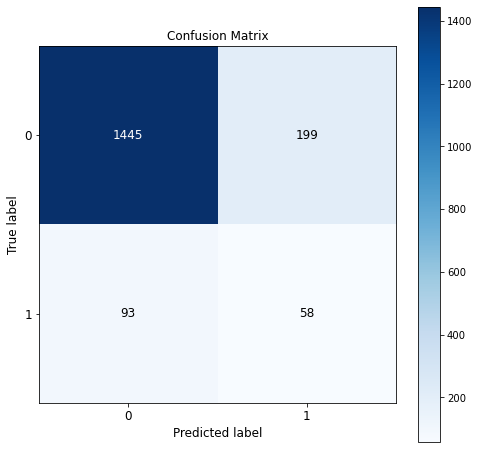

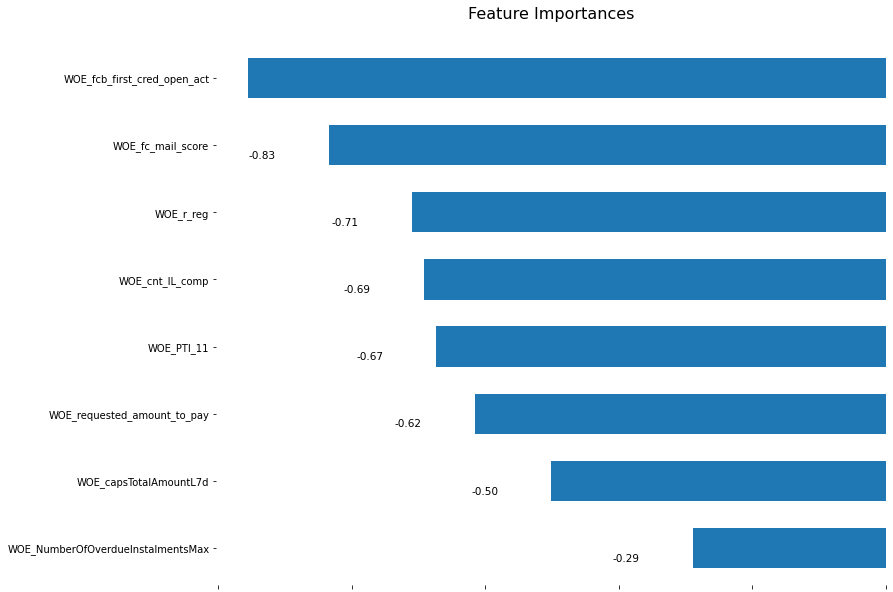

In [59]:
_X = np.vstack([X_train[vars_woe], X_test[vars_woe]])
_y = np.hstack([y_train, y_test])

_logreg = LogisticRegression(**params)
scores = 2*cross_val_score(_logreg, _X, _y, cv=5, scoring='roc_auc')-1
print ('Cross_val_scores: ', scores)

_logreg = logreg
IDF.plot_score(_logreg, X_test[vars_woe], y_test, X_train[vars_woe], y_train, cut_off=0.45)
print([_logreg.coef_[0], _logreg.intercept_[0] ])

In [61]:
date_name = 'date_requested'  # имя столбца даты по которому делить на месяцы
df3, feat = construct_df3(vars_woe, logreg, df_req, X_train, X_test, df_train, df_test, X_out=None, df_out=None, date_name=date_name)

# Pivot table of Score Buckets
table = pd.pivot_table(
    df3,
    index=['requested_month_year'],
    columns=['Score_bucket'],
    values=['Score'],
    aggfunc='count').fillna(0)

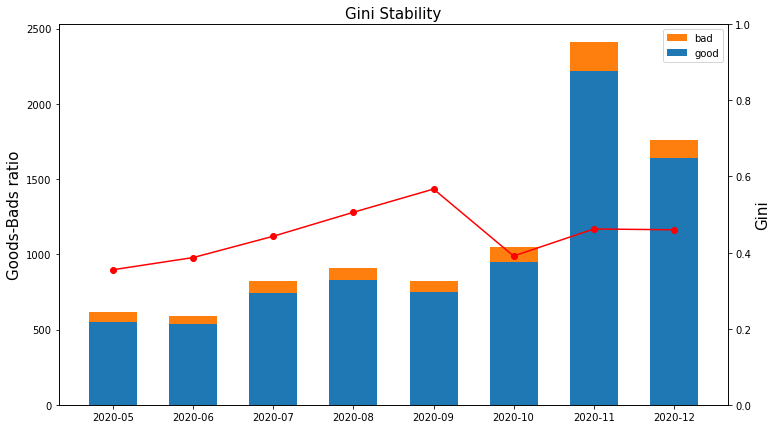

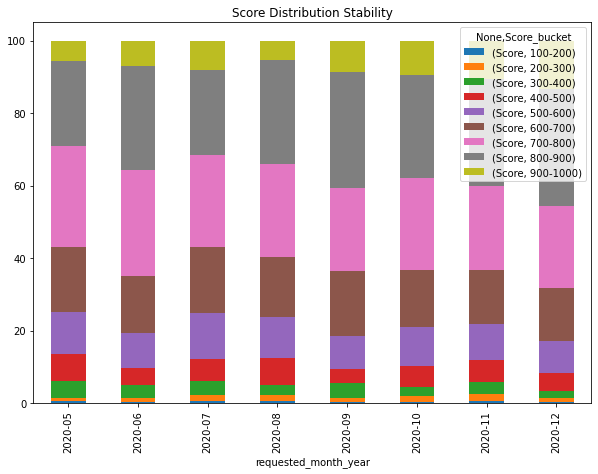

In [62]:
Ginis = create_gini_stability(df3, logreg, X_train[vars_woe])

pic_folder = 'pic/'  # Папка, в которую сохранятся картинки, надо отдельно создать её.
gini_stability_chart(Ginis, pic_folder=pic_folder)
score_stability_graph(table, pic_folder=pic_folder)

In [63]:
# Считаем однофакторный gini для train, test, out.
gini_by_vars = gini_univariate(X_train, X_test, X_out, y_train, y_test, y_out, vars_woe)

In [64]:
gini_by_vars

,vars,gini_train,gini_test,gini_out
1,WOE_cnt_IL_comp,0.267,0.278,0.293
3,WOE_capsTotalAmountL7d,0.245,0.201,0.217
0,WOE_requested_amount_to_pay,0.243,0.185,0.208
6,WOE_PTI_11,0.2,0.153,0.076
4,WOE_NumberOfOverdueInstalmentsMax,0.188,0.197,0.246
2,WOE_r_reg,0.17,0.178,0.274
5,WOE_fc_mail_score,0.161,0.149,0.035
7,WOE_fcb_first_cred_open_act,0.137,0.145,0.164


In [67]:
# Считаем однофакторный gini по месяцам.
date_name = 'date_requested'  # Дата, по которой делить на месяцы.
_, df_gini_months = gini_month_selection(df3[vars_woe], df3, date_name=date_name)

In [68]:
df_gini_months

,vars,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,2020-11,2020-12
0,WOE_requested_amount_to_pay,0.196,0.275,0.222,0.327,0.328,0.192,0.186,0.192
1,WOE_cnt_IL_comp,0.178,0.074,0.325,0.238,0.306,0.306,0.262,0.346
2,WOE_r_reg,0.005,0.292,0.034,0.235,0.161,0.169,0.222,0.188
3,WOE_capsTotalAmountL7d,0.157,0.253,0.232,0.355,0.196,0.192,0.237,0.215
4,WOE_NumberOfOverdueInstalmentsMax,0.144,0.120,0.189,0.056,0.268,0.170,0.212,0.275
5,WOE_fc_mail_score,0.113,0.059,0.110,0.148,0.171,0.130,0.180,0.108
6,WOE_PTI_11,0.151,0.139,0.179,0.273,0.345,0.048,0.206,0.159
7,WOE_fcb_first_cred_open_act,0.158,0.220,0.116,0.150,0.115,0.120,0.105,0.163


In [70]:
# Create ivi to excel
ivs = ivs_to_excel(iv_df, X_train[vars_woe])

# Score and IV groups
ivs = iv_groups(ivs)
ivs = add_score(ivs, feat, y_train)

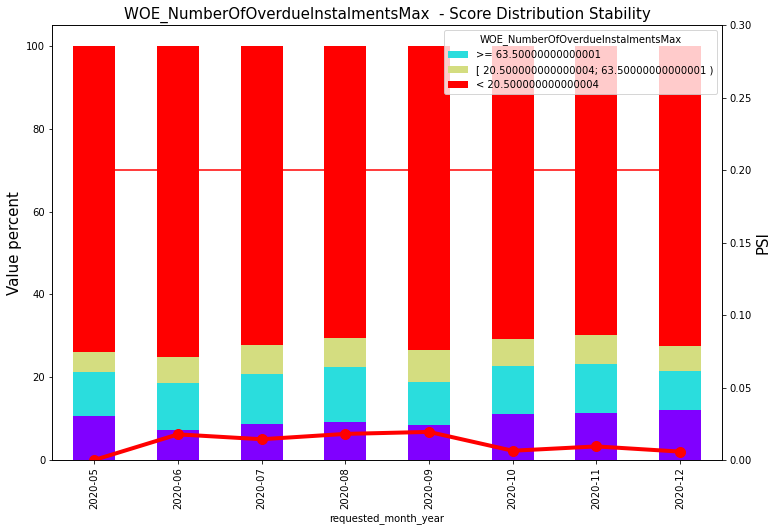

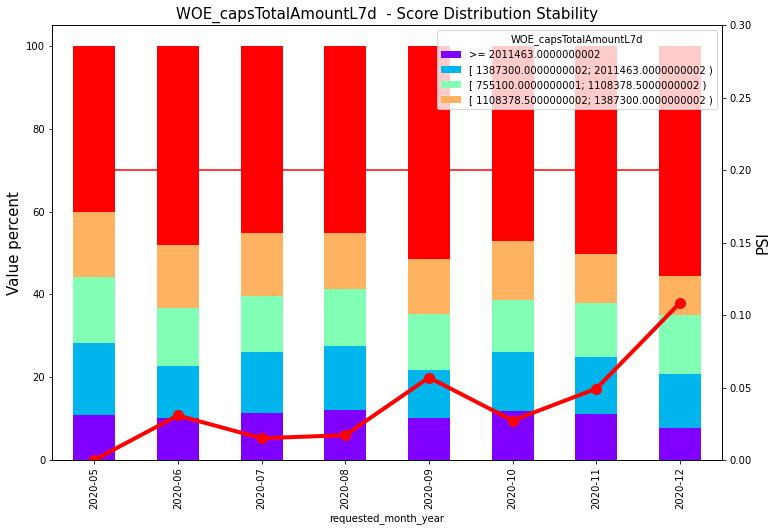

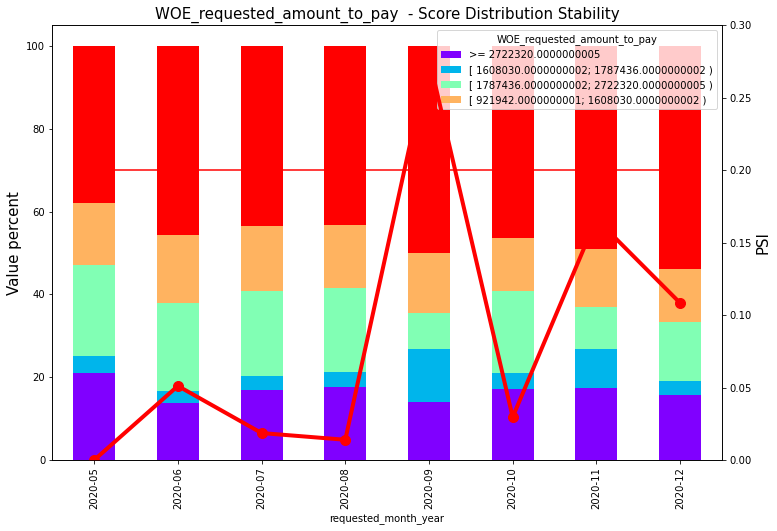

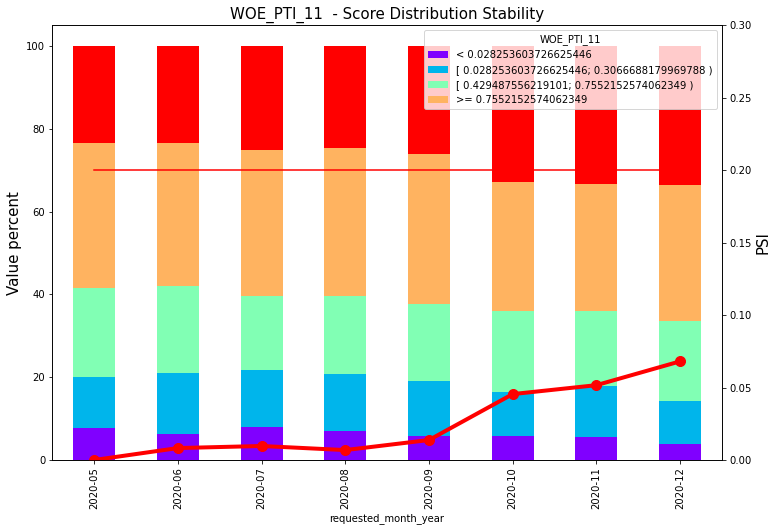

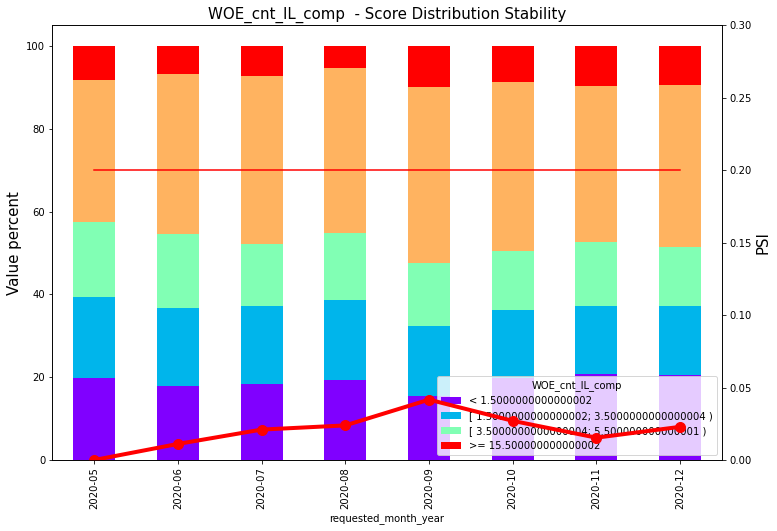

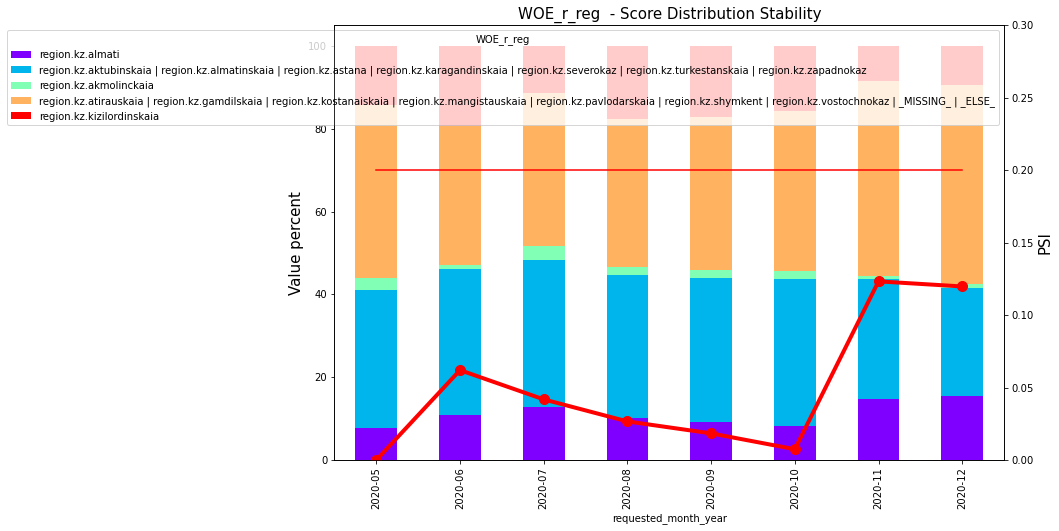

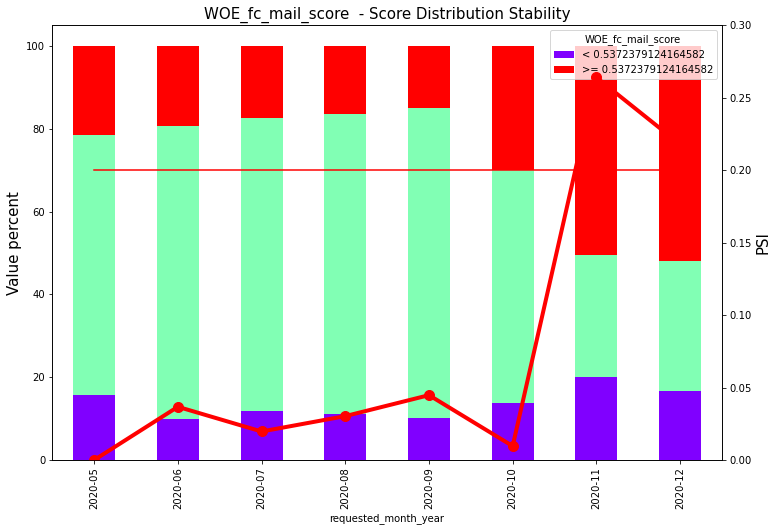

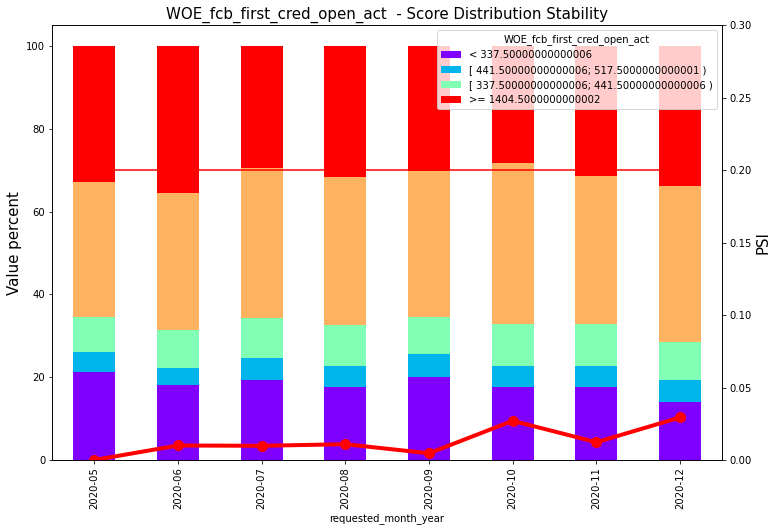

In [76]:
month_num = 0  # Номер месяца от которого отталкиваться в расчёте psi.
date_name = 'date_requested'  # имя столбца даты по которому делить на месяцы
features_of_model = population_stability(df3, ivs, feat, month_num=month_num, pic_folder=pic_folder, date_name=date_name)

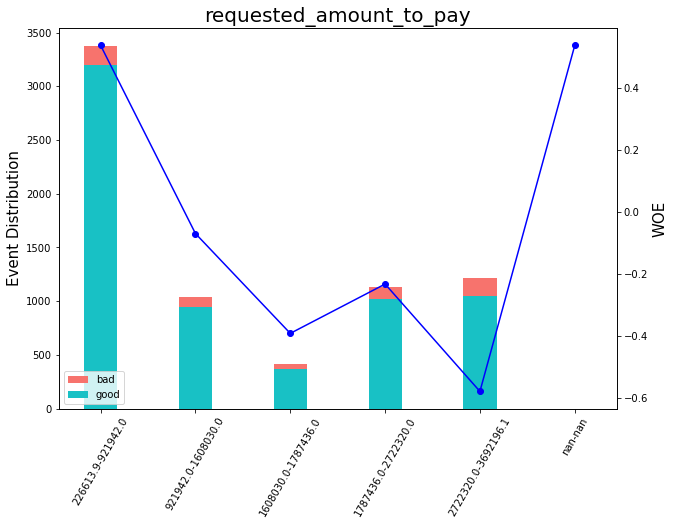

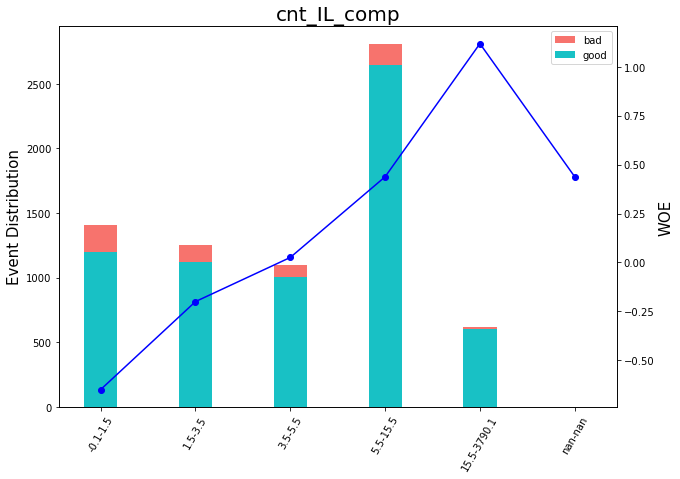

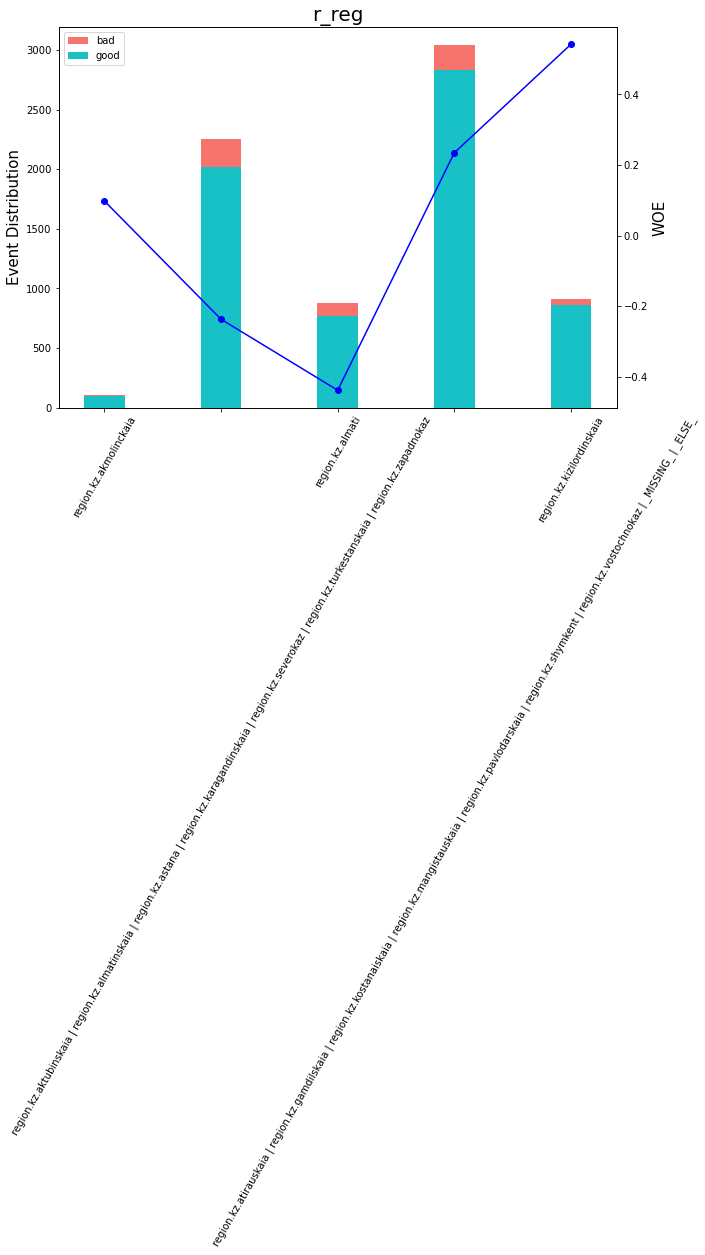

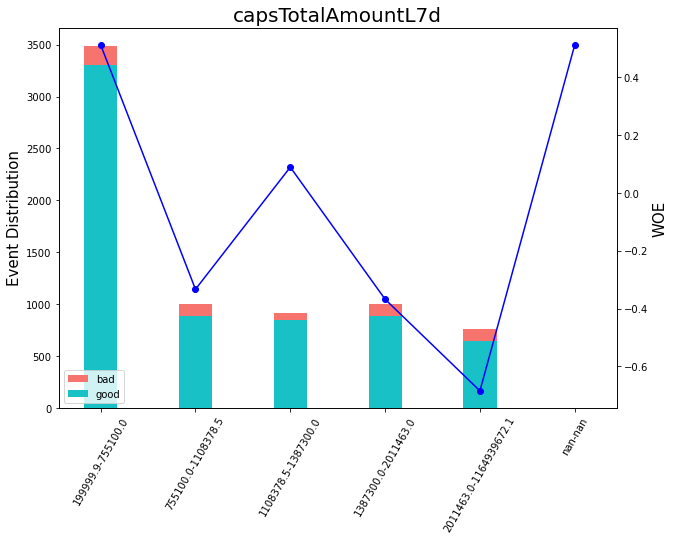

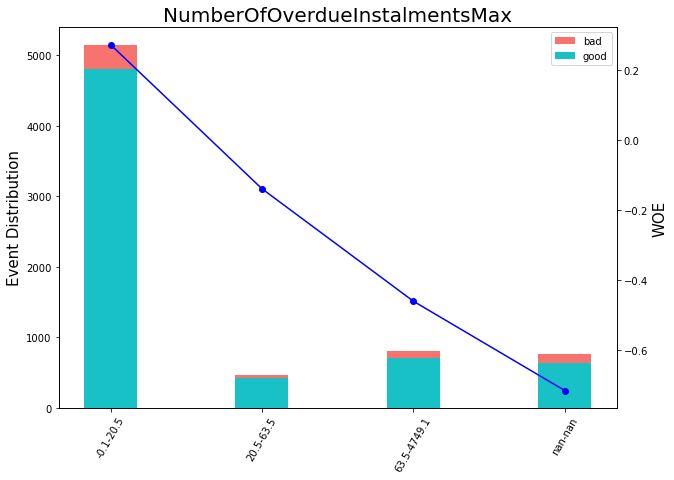

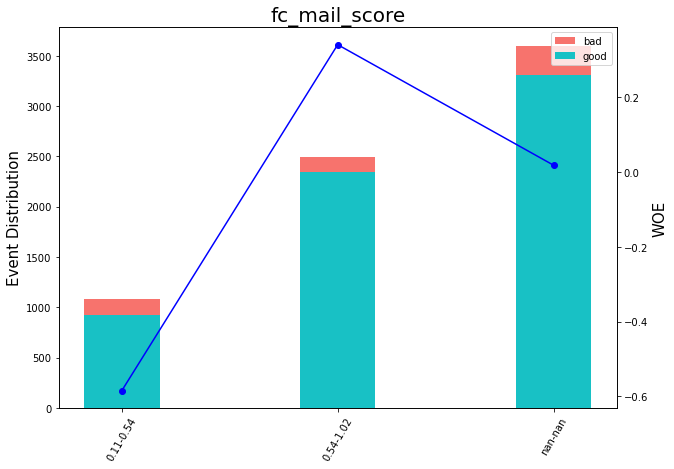

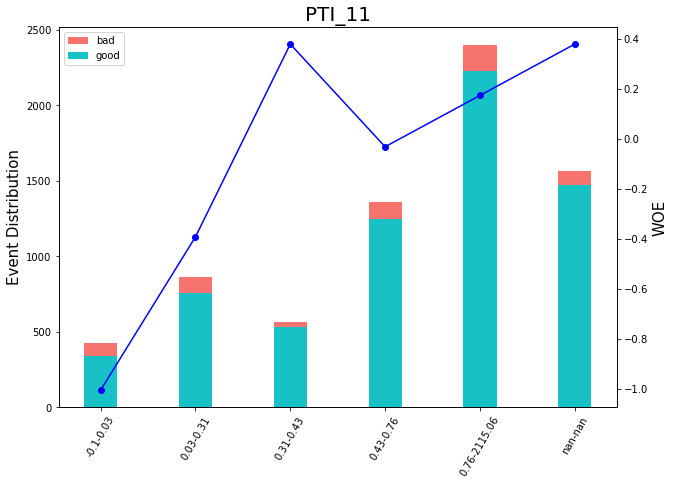

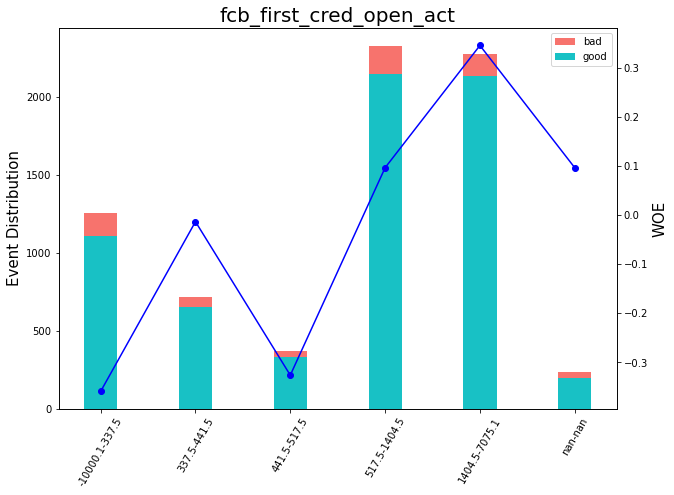

In [77]:
plot_all_bins(iv_df, X_train[vars_woe], pic_folder=pic_folder)

#### Корректировка биннинга
Если не треубется корректировать биннинг, то следующие 4 ячейки можно пропустить.

In [89]:
vars_to_rebin = ['requested_amount_to_pay',
                 'capsTotalAmountL7d',
                 'fcb_first_cred_open_act',
                 'r_reg',]
for var in vars_to_rebin:
    print_feature_bins(var, iv_df)

'requested_amount_to_pay': [(226613.9, 921942.0), (921942.0, 1608030.0), (1608030.0, 1787436.0), (1787436.0, 2722320.0), (2722320.0, 3692196.1), ('nan', 'nan', 0.5361080556850151)],
'capsTotalAmountL7d': [(199999.9, 755100.0), (755100.0, 1108378.5), (1108378.5, 1387300.0), (1387300.0, 2011463.0), (2011463.0, 1164939672.1), ('nan', 'nan', 0.5124864696156477)],
'fcb_first_cred_open_act': [(-10000.1, 337.5), (337.5, 441.5), (441.5, 517.5), (517.5, 1404.5), (1404.5, 7075.1), ('nan', 'nan', 0.09620546923201265)],
'r_reg': ['region.kz.akmolinckaia', 'region.kz.aktubinskaia | region.kz.almatinskaia | region.kz.astana | region.kz.karagandinskaia | region.kz.severokaz | region.kz.turkestanskaia | region.kz.zapadnokaz', 'region.kz.almati', 'region.kz.atirauskaia | region.kz.gamdilskaia | region.kz.kostanaiskaia | region.kz.mangistauskaia | region.kz.pavlodarskaia | region.kz.shymkent | region.kz.vostochnokaz | _MISSING_ | _ELSE_', 'region.kz.kizilordinskaia'],


In [149]:
new_bins = {
    'requested_amount_to_pay': [(226613.9, 921942.0), (921942.0, 1608030.0), (1608030.0, 2722320.0), (2722320.0, 3692196.1), ('nan', 'nan', 0.5361080556850151)],
    'capsTotalAmountL7d': [(199999.9, 755100.0), (755100.0, 1387300.0), (1387300.0, 2011463.0), (2011463.0, 1164939672.1), ('nan', 'nan', 0.5124864696156477)],
    'fcb_first_cred_open_act': [(-10000.1, 337.5), (337.5, 517.5), (517.5, 1404.5), (1404.5, 7075.1), ('nan', 'nan', 0.09620546923201265)],
    'r_reg': ['region.kz.aktubinskaia | region.kz.almatinskaia | region.kz.astana | region.kz.karagandinskaia | region.kz.severokaz | region.kz.turkestanskaia | region.kz.zapadnokaz', 'region.kz.almati', 'region.kz.atirauskaia | region.kz.gamdilskaia | region.kz.kostanaiskaia | region.kz.mangistauskaia | region.kz.pavlodarskaia | region.kz.shymkent | region.kz.vostochnokaz | region.kz.akmolinckaia | _MISSING_ | _ELSE_', 'region.kz.kizilordinskaia'],
}

new_iv_df = correct_binning_dict(new_bins, iv_df, df_train)

In [159]:
# feature = 'requested_amount_to_pay'
feature = list(new_bins.keys())[0]
display(iv_df[iv_df['VAR_NAME'] == feature])
display(new_iv_df[new_iv_df['VAR_NAME'] == feature])

,VAR_NAME,MIN_VALUE,MAX_VALUE,COUNT,DR,EVENT,EVENT_RATE,NONEVENT,NON_EVENT_RATE,WOE,IV
431,requested_amount_to_pay,226613.9,921942.0,3372,0.051008,172,0.284768,3200,0.486766,0.536108,0.200789
432,requested_amount_to_pay,921942.0,1608030.0,1037,0.089682,93,0.153974,944,0.143596,-0.069777,0.200789
433,requested_amount_to_pay,1608030.0,1787436.0,418,0.119617,50,0.082781,368,0.055978,-0.391244,0.200789
434,requested_amount_to_pay,1787436.0,2722320.0,1136,0.103873,118,0.195364,1018,0.154852,-0.232393,0.200789
435,requested_amount_to_pay,2722320.0,3692196.1,1215,0.140741,171,0.283113,1044,0.158807,-0.578152,0.200789
436,requested_amount_to_pay,NaN,NaN,0,0,0,0,0,0,0.536108,0.200789


,VAR_NAME,MIN_VALUE,MAX_VALUE,COUNT,DR,EVENT,EVENT_RATE,NONEVENT,NON_EVENT_RATE,WOE,IV
734,requested_amount_to_pay,226613.9,921942.0,3372,0.051008,172,0.284768,3200,0.486766,0.536108,0.199536
735,requested_amount_to_pay,921942.0,1608030.0,1037,0.089682,93,0.153974,944,0.143596,-0.069777,0.199536
736,requested_amount_to_pay,1608030.0,2722320.0,1554,0.108108,168,0.278146,1386,0.210831,-0.27709,0.199536
737,requested_amount_to_pay,2722320.0,3692196.1,1215,0.140741,171,0.283113,1044,0.158807,-0.578152,0.199536
738,requested_amount_to_pay,NaN,NaN,0,0.0,0,0.0,0,0.0,0.536108,0.199536


In [162]:
# Сохраняем WOE таблицу для итоговых переменных с новым биннигом.
new_iv_df[new_iv_df['VAR_NAME'].isin(var_name_original(vars_woe))].to_excel('result/new_iv_df.xlsx', index=False)

# Если требуется запустить заново построение карты с новым биннингом,
# то лучше всего использовать отдельный jupyter notebook, в котором можно
# загрузить данный файл и произвести заново построение карты + расчет параметров для оценки.
# Если это не требуется, то можно продолжить построение итогового отчета в этом файле.

#### Формирование итогового excel файла

In [164]:
model = sm.Logit(y_train, X_train[vars_woe])
model_fit = model.fit()
model_fit.pvalues

PV = pd.DataFrame(data=model_fit.pvalues, columns=['pv_train'])
PV = PV.sort_values(by='pv_train', ascending=False)
# PV.to_excel('results/pvalues.xlsx')

Optimization terminated successfully.
         Current function value: 0.582207
         Iterations 5


In [165]:
target_description = 'npl1_3mob'
model_description = 'Скоркарта Solva KZ сегмента street'

DSL = generate_DSL(ivs, feat, nan_to_woe='max_cat', else_to_woe='max_cat')
SQL = generate_SQL(ivs, feat, nan_to_woe='max_cat', else_to_woe='max_cat')
SQL = SQL.replace('+ --', '+ ')

clf_lr = logreg
name_2 = 'slkz_solvaStreet_score_v1.1'

export_to_excel(
    DSL=DSL,
    SQL=SQL,
    X_train=X_train[vars_woe],
    X_test=X_test[vars_woe],
    y_train=y_train,
    y_test=y_test,
    y=y,
    df3=df3,
    iv_df=iv_df,
    ivs=ivs,
    Ginis=Ginis,
    table=table,
    scores=scores,
    feat=feat,
    features_of_model=features_of_model,
    clf_lr=clf_lr,
    gini_by_vars=gini_by_vars,
    PV=PV,
    X_out=X_out[vars_woe],
    y_out=y_out,
    name=name_2,
    pic_folder='pic/',
    target_description=target_description,
    model_description=model_description
)

Exported!
